# Project Progress Report
**Date:** April 10th, 2025

**Team Members:**
Angel Ramirez,
[Name 2]
[Name 3]

**Link to GitHub Repository:** https://github.com/mmadr5/SteamSalesAndPricingAnalysis

# ===========================================

# 1. Project Introduction
Briefly introduce your project, the dataset, and the problems you aim to investigate.

"""
[Write your introduction here. Discuss the data source, domain, and research questions or problems you are addressing.]
"""

# ===========================================

# 2. Changes since Proposal
Discuss any changes in the scope or approach since the initial proposal.

"""
Parts removed:
- [Removed item 1]
- [Removed item 2]

Parts added:
- [Added item 1]
- [Added item 2]
"""


# ===========================================

# 3. Data Preparation
Explain the steps taken to prepare your data.

"""
[Describe your data preparation process, including data cleaning, transformations, feature extraction, etc.]
"""


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('../Steam_Project/steam_top100_cleaned_data_corrected.csv')

print("First 5 rows of the dataset:")
display(df.head())

# Dataset overview
print("\nData Info:")
df.info()

print("\nStatistical Summary:")
display(df.describe())

# Convert price to numeric and fix decimal
# Some prices are stored as integers like 9999 instead of 99.99
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Filter price between 0 and 210 (exclusive of 0)
df = df[(df['price'] > 0) & (df['price'] <= 210)]

# Drop duplicate app entries (keep first occurrence)
df.drop_duplicates(subset='appid', keep='first', inplace=True)

# Add total_reviews and positive_ratio columns
df['total_reviews'] = df['positive'] + df['negative']
df['positive_ratio'] = df['positive'] / (df['total_reviews'].replace(0, 1))  # Avoid divide by zero

# Check for missing values
print("\nMissing Values Per Column:")
print(df.isnull().sum())

# Optional: drop rows with critical missing values (e.g., no name or no genre)
df.dropna(subset=['name', 'genre'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Preview cleaned data
print("\nCleaned Data Sample:")
display(df.head())

First 5 rows of the dataset:


,appid,name,developer,publisher,price,positive,negative,genre
0,1623730,Palworld,Pocketpair,Pocketpair,29.99,353750,22031,Action
1,1063730,New World: Aeternum,Amazon Games,Amazon Games,79.99,196554,89844,Action
2,2358720,Black Myth: Wukong,Game Science,Game Science,59.99,1103540,38012,Action
3,1938090,Call of Duty: Modern Warfare II,"Treyarch, Raven Software, Beenox, High Moon St...",Activision,48.99,409407,288694,Action
4,550,Left 4 Dead 2,Valve,Valve,9.99,928245,23442,Action



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151092 entries, 0 to 151091
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   appid      151092 non-null  int64  
 1   name       151073 non-null  object 
 2   developer  150994 non-null  object 
 3   publisher  150529 non-null  object 
 4   price      151092 non-null  float64
 5   positive   151092 non-null  int64  
 6   negative   151092 non-null  int64  
 7   genre      151092 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 9.2+ MB

Statistical Summary:


,appid,price,positive,negative
count,1.510920e+05,151092.000000,1.510920e+05,151092.000000
mean,1.464639e+06,9.214309,1.403164e+03,191.953101
std,8.116983e+05,13.984803,1.890955e+04,2369.983623
min,1.000000e+01,0.270000,0.000000e+00,0.000000
25%,7.838600e+05,2.990000,5.000000e+00,1.000000
50%,1.366260e+06,5.990000,1.800000e+01,6.000000
75%,2.096840e+06,10.990000,1.020000e+02,29.000000
max,3.375310e+06,999.000000,1.357715e+06,288694.000000



Missing Values Per Column:
appid               0
name                5
developer          31
publisher         244
price               0
positive            0
negative            0
genre               0
total_reviews       0
positive_ratio      0
dtype: int64

Cleaned Data Sample:


,appid,name,developer,publisher,price,positive,negative,genre,total_reviews,positive_ratio
0,1623730,Palworld,Pocketpair,Pocketpair,29.99,353750,22031,Action,375781,0.941373
1,1063730,New World: Aeternum,Amazon Games,Amazon Games,79.99,196554,89844,Action,286398,0.686297
2,2358720,Black Myth: Wukong,Game Science,Game Science,59.99,1103540,38012,Action,1141552,0.966701
3,1938090,Call of Duty: Modern Warfare II,"Treyarch, Raven Software, Beenox, High Moon St...",Activision,48.99,409407,288694,Action,698101,0.586458
4,550,Left 4 Dead 2,Valve,Valve,9.99,928245,23442,Action,951687,0.975368


# ===========================================

# 4. Exploratory Data Analysis (EDA)


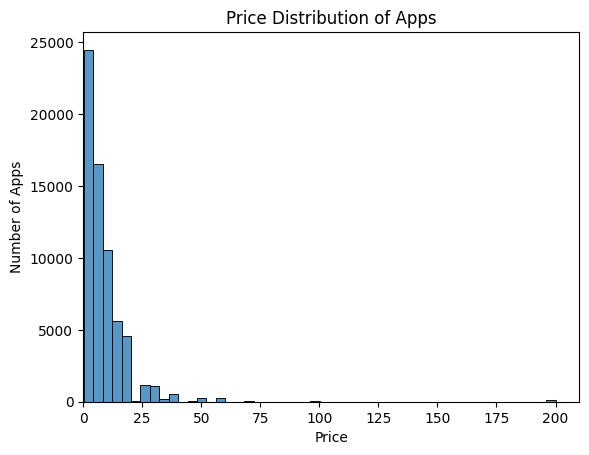

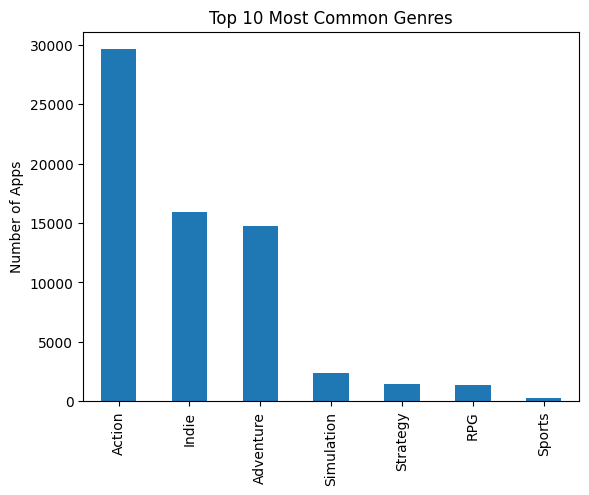

In [3]:

sns.histplot(df['price'], bins=50)

plt.title("Price Distribution of Apps")
plt.xlim(0, 210)  # Limit x-axis to 0-100 for better visibility
plt.xlabel("Price")
plt.ylabel("Number of Apps")
plt.show()

# Most common genres
from collections import Counter

all_genres = ','.join(df['genre'].dropna()).split(',')
genre_counts = pd.Series(Counter(all_genres)).sort_values(ascending=False)
genre_counts.head(10).plot(kind='bar')
plt.title("Top 10 Most Common Genres")
plt.ylabel("Number of Apps")
plt.show()

# ===========================================

# 5. Hypotheses Visualizations
(At least 5 visualizations with explanations and responsible team members)


### Hypothesis 1:
- Visualization explanation: Free apps get more reviews than paid apps
- Responsible member(s): Angel Ramirez
- Why it’s interesting: Helps understand if pricing strategy impacts popularity.


In [ ]:
# Add 'is_free' column to indicate whether the app is free
df['is_free'] = df['price'] == 0.00

# Add 'log_reviews' column to calculate log(1 + total_reviews)
import numpy as np
df['log_reviews'] = np.log1p(df['total_reviews'])

# Plot the violin plot
sns.violinplot(x='is_free', y='log_reviews', data=df, inner='box')
plt.title("Free vs Paid Apps: Log Review Count (Violin Plot)")
plt.xlabel("Is Free")
plt.ylabel("Log(1 + Total Reviews)")
plt.show()

### Hypothesis 2:
- Visualization explanation:
- Responsible member(s):

In [ ]:
# [Visualization Code]

### Hypothesis 3:
- Visualization explanation:
- Responsible member(s):

In [ ]:
# [Visualization Code]

### Hypothesis 4:
- Visualization explanation:
- Responsible member(s):

In [ ]:
# [Visualization Code]

### Hypothesis 5:
- Visualization explanation:
- Responsible member(s):

In [ ]:
# [Visualization Code]

# 6. Machine Learning Analyses
(At least 2 analyses with baselines and explanations)

**Analysis 1:**
- ML technique explanation:
- Baseline used:
- Results interpretation:
- Responsible member(s):

In [ ]:
# [ML Analysis Code]

**Analysis 2:**
- ML technique explanation:
- Baseline used:
- Results interpretation:
- Responsible member(s):

In [ ]:
# [ML Analysis Code]

# ===========================================

# 7. Reflection
Address the reflection points:

- Most challenging part so far:

- Initial insights:

- Concrete results available:

- Current biggest problems:

- Are you on track?

- Worth proceeding with the current approach?

# ===========================================

# 8. Next Steps
Outline concrete plans and goals for the next month.

- [Goal 1]
- [Goal 2]
- [Goal 3]